In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to GANs

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture. 

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN. 



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataloader = DataLoader(dataset=mnist_train, 
                         batch_size=batch_size,
                         shuffle=True)    

In [ ]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

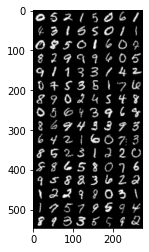

In [ ]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm 
- ReLU

In [ ]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU, 
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
        return nn.Sequential(
                nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding, bias=False),
                nn.Tanh(),
            )

    else:
        return nn.Sequential(
                nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding, bias=False),
                nn.BatchNorm2d(channels_out),
                nn.ReLU(),
            )



class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super(Generator, self).__init__()
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        
        self.model = nn.Sequential(
            get_upscaling_block(nz,ngf*4,4,1,0),
            get_upscaling_block(ngf*4,ngf*2,4,2,1),
            get_upscaling_block(ngf*2,ngf,4,2,1),
            get_upscaling_block(ngf,nchannels,4,2,1, True),
        )
        
        ###################
        
    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)
        

### 2.1.3. Sanity Tests

In [ ]:
nz = 1000
z = torch.randn(batch_size, nz)

In [ ]:
G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

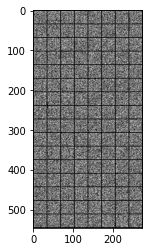

In [ ]:
# visualize the output - at first it should just look like random noise!!
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)));

## 2.2. The discriminator

The discriminator will be a mirror image of the generator. 

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]` 

In [ ]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    
    if is_last:
        return nn.Sequential(
                nn.Conv2d(channels_in, channels_out, kernel, stride, padding, bias=False),
                nn.Sigmoid(),
            )
    
    elif not use_batch_norm:
        return nn.Sequential(
                nn.Conv2d(channels_in, channels_out, kernel, stride, padding, bias=False),
                nn.LeakyReLU(0.2),
            )
    
    else:
        return nn.Sequential(
                nn.Conv2d(channels_in, channels_out, kernel, stride, padding, bias=False),
                nn.BatchNorm2d(channels_out),
                nn.LeakyReLU(0.2),
            )
    
    


class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super(Discriminator, self).__init__()
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        
        self.model = nn.Sequential(
            get_downscaling_block(1,ndf,4,2,1),
            get_downscaling_block(ndf,ndf*2,4,2,1),
            get_downscaling_block(ndf*2,ndf*4,4,2,1),
            get_downscaling_block(ndf*4,nchannels,4,1,0,is_last=True),
        )
        
        #                 #
        ###################

    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 2.2.3 Sanity Checking

In [ ]:
real_batch, real_labels = next(iter(dataloader))

In [ ]:
D = Discriminator(ndf=32, nchannels=1)
assert D(real_batch).shape == (real_batch.shape[0], 1)

# 3. Training

## 3.1 Loss 
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [ ]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions. 
1. First, we need to continuously sample z from a Gaussian distribution. 
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s. 

In [ ]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1) 
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training! 
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve. 
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

it: 0; g_loss: 1.1341654062271118; d_loss: 0.6654337048530579; avg_real_score: 0.5376813411712646; avg_fake_score: 0.3393156826496124: : 0it [00:00, ?it/s]

generated images


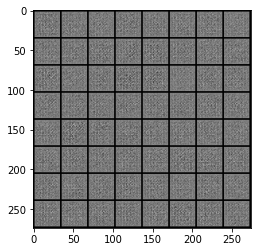

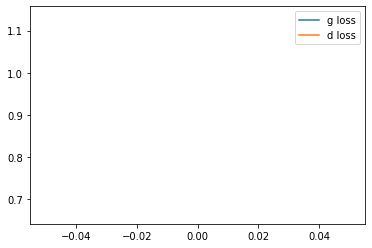

it: 200; g_loss: 2.1483936309814453; d_loss: 0.28911319375038147; avg_real_score: 0.7563043832778931; avg_fake_score: 0.13672378659248352: : 200it [00:20, 10.17it/s]

generated images


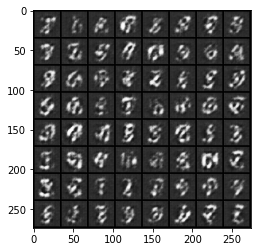

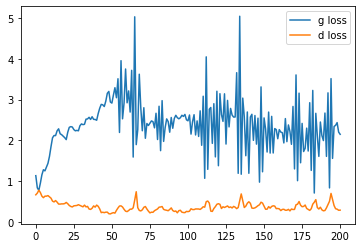

it: 400; g_loss: 1.5934022665023804; d_loss: 0.23003165423870087; avg_real_score: 0.7840296030044556; avg_fake_score: 0.22100377082824707: : 400it [00:40, 10.35it/s]

generated images


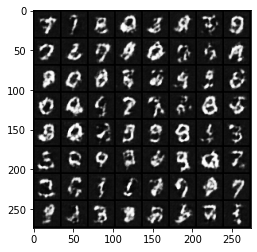

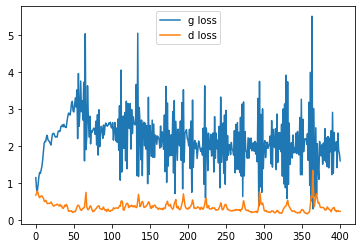

it: 468; g_loss: 1.2987995147705078; d_loss: 0.48149022459983826; avg_real_score: 0.6258461475372314; avg_fake_score: 0.29510635137557983: : 469it [00:48,  9.77it/s]
it: 469; g_loss: 1.7341232299804688; d_loss: 0.38927456736564636; avg_real_score: 0.7123897075653076; avg_fake_score: 0.1921520084142685: : 0it [00:00, ?it/s]

generated images


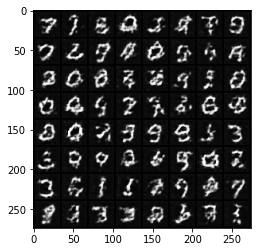

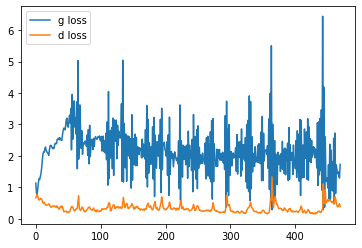

it: 669; g_loss: 4.36415958404541; d_loss: 0.7822527289390564; avg_real_score: 0.9815395474433899; avg_fake_score: 0.015157271176576614: : 200it [00:20, 10.17it/s]   

generated images


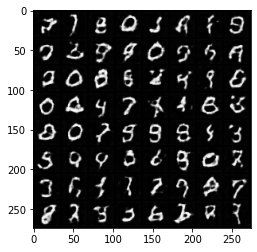

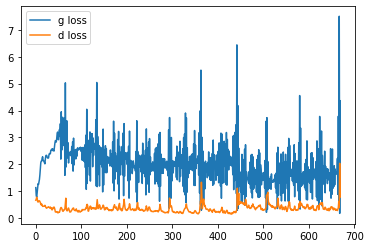

it: 869; g_loss: 0.47840631008148193; d_loss: 0.5884994864463806; avg_real_score: 0.39007943868637085; avg_fake_score: 0.6338261365890503: : 400it [00:41,  9.82it/s]

generated images


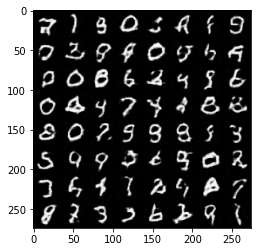

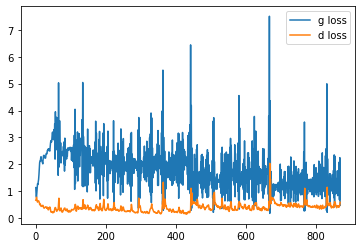

it: 937; g_loss: 0.8509728312492371; d_loss: 0.4272257089614868; avg_real_score: 0.5415302515029907; avg_fake_score: 0.4475090205669403: : 469it [00:48,  9.58it/s]
it: 938; g_loss: 2.2810416221618652; d_loss: 0.42766064405441284; avg_real_score: 0.860905647277832; avg_fake_score: 0.11520634591579437: : 0it [00:00, ?it/s]

generated images


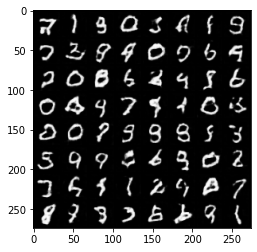

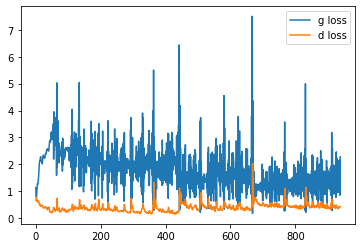

it: 1138; g_loss: 1.6678012609481812; d_loss: 0.36022865772247314; avg_real_score: 0.6670976877212524; avg_fake_score: 0.21104784309864044: : 200it [00:21,  9.25it/s]

generated images


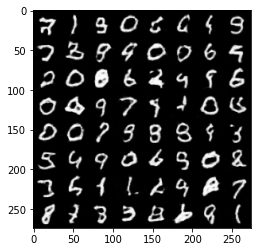

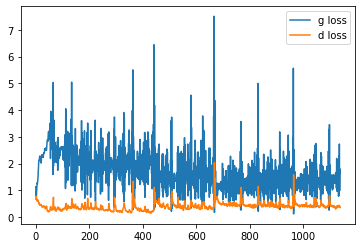

it: 1338; g_loss: 0.579261064529419; d_loss: 0.45727071166038513; avg_real_score: 0.4753108620643616; avg_fake_score: 0.5756906270980835: : 400it [00:42,  9.76it/s]  

generated images


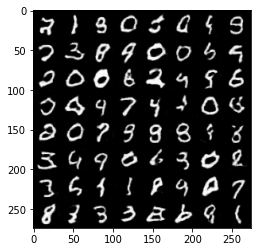

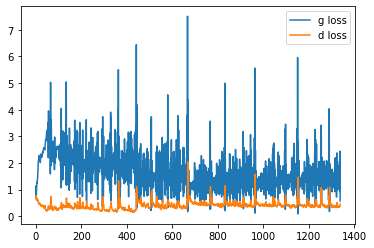

it: 1406; g_loss: 2.2385196685791016; d_loss: 0.28111186623573303; avg_real_score: 0.8474183082580566; avg_fake_score: 0.11840099096298218: : 469it [00:49,  9.39it/s]
it: 1407; g_loss: 1.1657512187957764; d_loss: 0.33790838718414307; avg_real_score: 0.6255303621292114; avg_fake_score: 0.33775055408477783: : 0it [00:00, ?it/s]

generated images


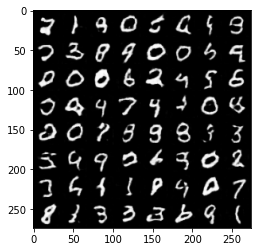

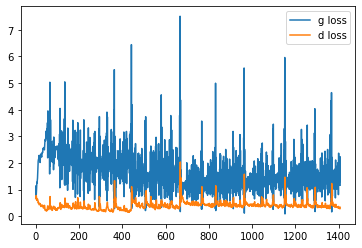

it: 1607; g_loss: 0.9673396348953247; d_loss: 0.31404224038124084; avg_real_score: 0.6549074649810791; avg_fake_score: 0.40177685022354126: : 200it [00:21,  9.12it/s]

generated images


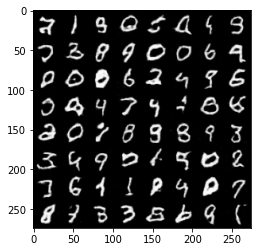

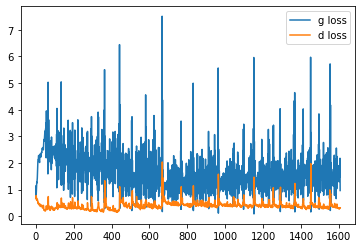

it: 1807; g_loss: 2.641855478286743; d_loss: 0.46271127462387085; avg_real_score: 0.8687232136726379; avg_fake_score: 0.08174505084753036: : 399it [00:43,  8.91it/s] 

generated images


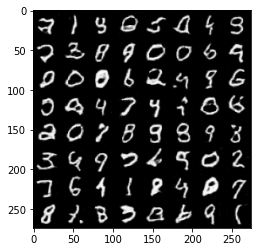

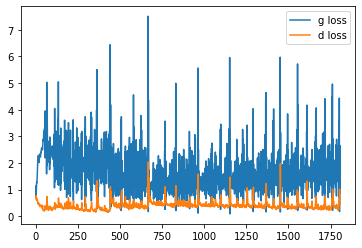

it: 1875; g_loss: 1.572257399559021; d_loss: 0.24650907516479492; avg_real_score: 0.7758612632751465; avg_fake_score: 0.22522884607315063: : 469it [00:51,  9.18it/s]
it: 1876; g_loss: 2.4335827827453613; d_loss: 0.2177974283695221; avg_real_score: 0.8578418493270874; avg_fake_score: 0.103016197681427: : 0it [00:00, ?it/s]

generated images


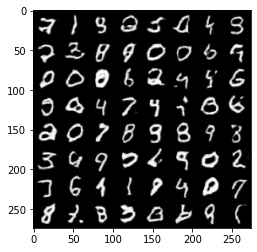

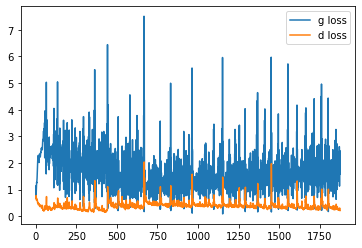

it: 2076; g_loss: 1.9323549270629883; d_loss: 0.3712082505226135; avg_real_score: 0.8166217803955078; avg_fake_score: 0.16573867201805115: : 200it [00:22,  9.26it/s]

generated images


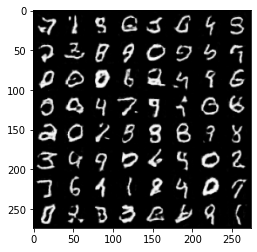

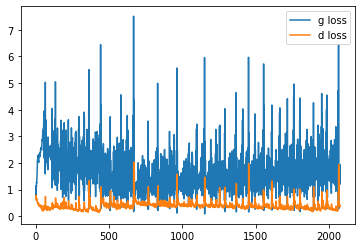

it: 2276; g_loss: 2.414264678955078; d_loss: 0.18635082244873047; avg_real_score: 0.7487514615058899; avg_fake_score: 0.10771369934082031: : 400it [00:45,  9.04it/s]  

generated images


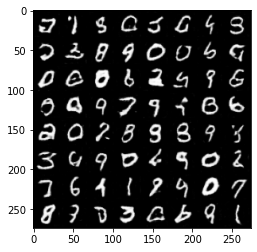

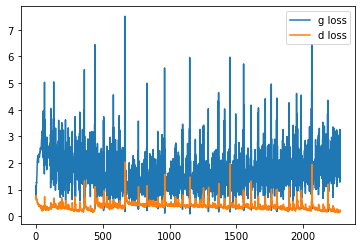

it: 2344; g_loss: 0.4193929135799408; d_loss: 0.6614746451377869; avg_real_score: 0.3554645776748657; avg_fake_score: 0.6750181913375854: : 469it [00:52,  8.86it/s]


In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):
    
    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        # 1. sample a z vector 
        z = sample_z(im.shape[0], nz)
        
        # 2. Generate a fake image

        fake = netG(z)

        # 3. Classify real image with D

        real_class = netD(im)

        # 4. Classify fake image with D

        fake_class = netD(fake)

        
        
        ###
        ### Discriminator
        ###

        real_loss = criterion(real_class, get_labels_one(real_class.shape[0]))
        fake_loss = criterion(fake_class, get_labels_zero(fake_class.shape[0]))

        d_loss = (real_loss + fake_loss)/2
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        
        ###
        ### Generator
        ###

        fake = netG(z)
        fake_class = netD(fake)
        
        g_loss = criterion(fake_class, get_labels_one(fake_class.shape[0]))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = real_class.mean().item()
        avg_fake_score = fake_class.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)  
            
            print("generated images")
            plt.imshow(pil_grid)
            plt.show()
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1

# 4. Conditional GANs [BONUS]

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 4.1 Conditional Generator and Discriminator

Complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


### 4.1.1 Generator

In [ ]:
# GENERATOR

'''
The conditional generator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized 

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()
        
        self.upscaling_z = get_upscaling_block(nz, ngf*8, 4, 1, 0)
        self.upscaling_c = get_upscaling_block(nc, ngf*8, 4, 1, 0)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        self.rest_model = nn.Sequential(
            get_upscaling_block(ngf*16, ngf*8, 4, 2, 1),
            get_upscaling_block(ngf*8, ngf*4, 4, 2, 1),
            get_upscaling_block(ngf*4, nchannels, 4, 2, 1, True),
        )
        
        ###################
        
    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        x = self.upscaling_z(x)
        y = self.upscaling_c(y)
        return self.rest_model(torch.concat((x,y), axis=1))

### 4.1.2 Discriminator

In [ ]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized 

'''
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=False)
        self.downscale_y = get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=False)

        self.expand_dim = nn.Linear(10, 10*32*32)
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        
        self.rest = nn.Sequential(
            get_downscaling_block(ngf*4, ngf*8, 4, 2, 1, use_batch_norm=False),
            get_downscaling_block(ngf*8, ngf*16, 4, 2, 1, use_batch_norm=False),
            get_downscaling_block(ngf*16, nchannels, 4, 2, 0, is_last = True),
        )
        
        #                 #
        ###################
        
    def forward(self, x, y):
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        x = self.downscale_x(x)
        y = self.expand_dim(y).view(-1,10,32,32)
        y = self.downscale_y(y)

        
        return self.rest(torch.concat((x,y), axis=1)).squeeze(1).squeeze(1) # remove spatial dimensions

### 4.1.3 Sanity Checks

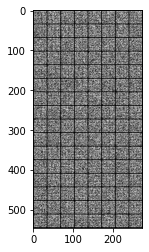

In [ ]:
# CONDITIONAL GENERATOR SANITY CHECKING

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

In [ ]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)
assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

## 4.2 Training

In [ ]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)
        
netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



it: 0; g_loss: 0.7178550958633423; d_loss: 0.6923608779907227; avg_real_score: 0.5005327463150024; avg_fake_score: 0.48781266808509827: : 0it [00:00, ?it/s]

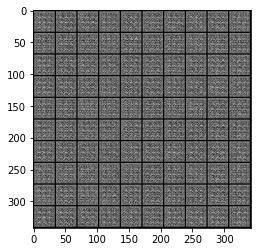

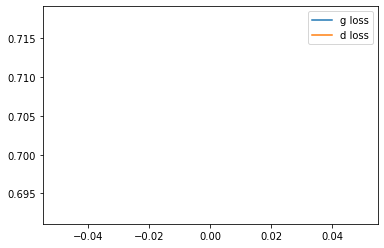

it: 200; g_loss: 0.9290289282798767; d_loss: 0.6033106446266174; avg_real_score: 0.5605620741844177; avg_fake_score: 0.40130501985549927: : 200it [01:35,  2.12it/s]

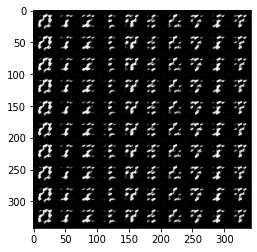

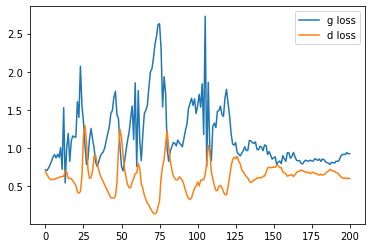

it: 400; g_loss: 0.7841806411743164; d_loss: 0.6620738506317139; avg_real_score: 0.5181258916854858; avg_fake_score: 0.45765504240989685: : 400it [03:11,  2.10it/s]

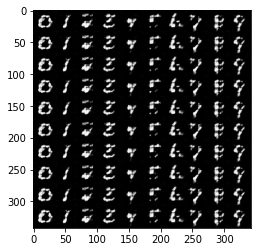

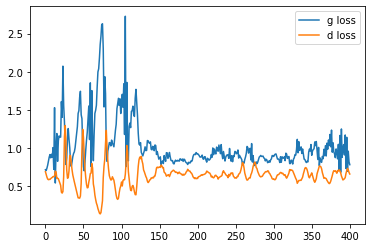

it: 468; g_loss: 0.8686015009880066; d_loss: 0.6583640575408936; avg_real_score: 0.48778748512268066; avg_fake_score: 0.4230641722679138: : 469it [03:44,  2.09it/s]
it: 469; g_loss: 1.063265323638916; d_loss: 0.6205953359603882; avg_real_score: 0.5672725439071655; avg_fake_score: 0.34928494691848755: : 0it [00:00, ?it/s]

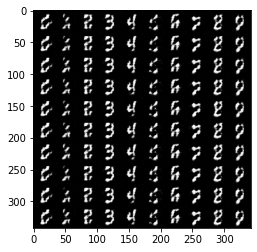

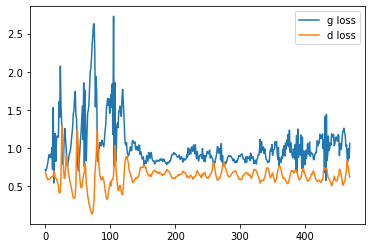

it: 669; g_loss: 1.391522765159607; d_loss: 0.6083194613456726; avg_real_score: 0.6306867599487305; avg_fake_score: 0.2575806975364685: : 200it [01:36,  2.08it/s]

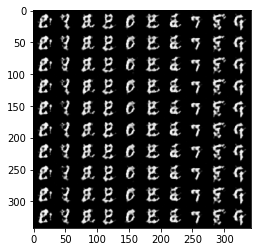

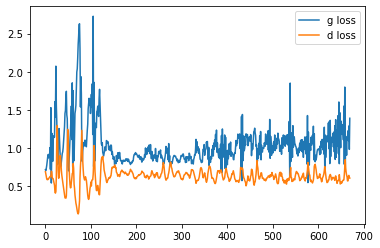

it: 869; g_loss: 0.6078195571899414; d_loss: 0.6423487663269043; avg_real_score: 0.5621523857116699; avg_fake_score: 0.5529125928878784: : 400it [03:13,  2.08it/s]

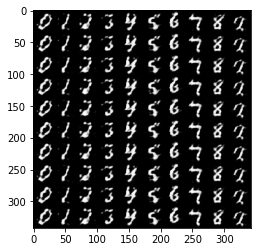

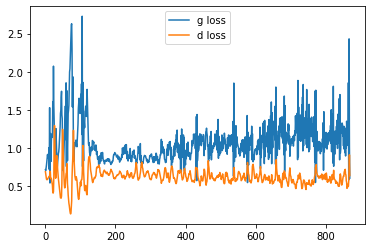

it: 937; g_loss: 1.0537904500961304; d_loss: 0.5477604866027832; avg_real_score: 0.5693268179893494; avg_fake_score: 0.3558923602104187: : 469it [03:46,  2.07it/s]
it: 938; g_loss: 1.328433632850647; d_loss: 0.5801027417182922; avg_real_score: 0.6177114248275757; avg_fake_score: 0.27314436435699463: : 0it [00:00, ?it/s]

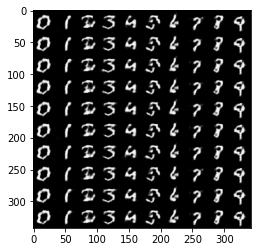

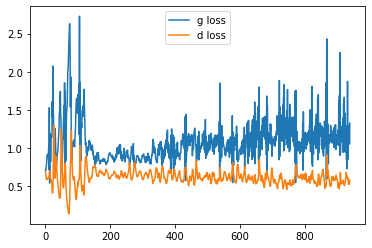

it: 1138; g_loss: 1.0330569744110107; d_loss: 0.6536441445350647; avg_real_score: 0.5309624671936035; avg_fake_score: 0.3602127432823181: : 200it [01:37,  2.06it/s]

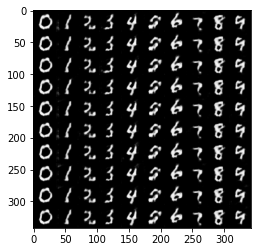

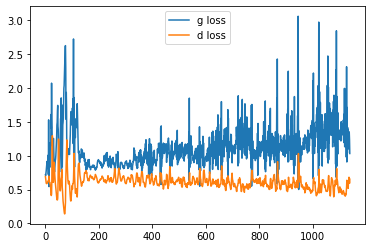

it: 1338; g_loss: 1.1295545101165771; d_loss: 0.5704715251922607; avg_real_score: 0.61839759349823; avg_fake_score: 0.3299453556537628: : 400it [03:13,  2.09it/s]  

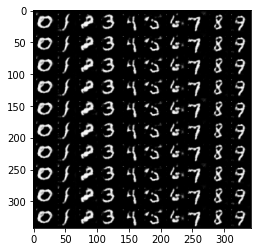

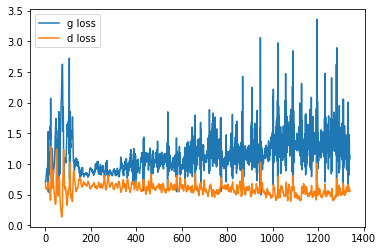

it: 1406; g_loss: 1.4844611883163452; d_loss: 0.4876057505607605; avg_real_score: 0.6260348558425903; avg_fake_score: 0.2299349009990692: : 469it [03:47,  2.06it/s]
it: 1407; g_loss: 0.8362691402435303; d_loss: 0.5807281732559204; avg_real_score: 0.5450749397277832; avg_fake_score: 0.4360211491584778: : 0it [00:00, ?it/s]

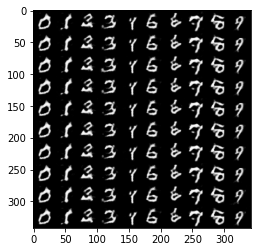

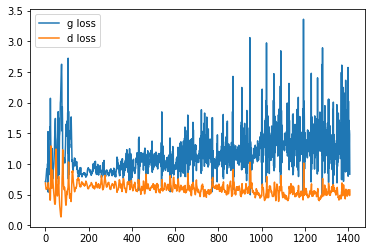

it: 1607; g_loss: 1.3014930486679077; d_loss: 0.39507079124450684; avg_real_score: 0.6248281598091125; avg_fake_score: 0.28659912943840027: : 200it [01:38,  2.05it/s]

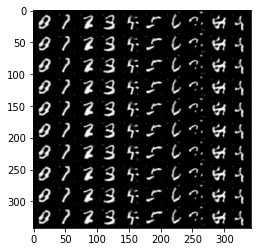

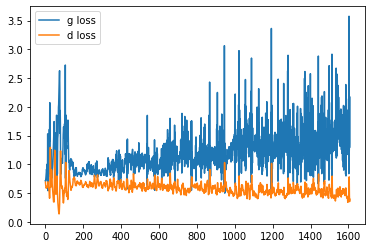

it: 1807; g_loss: 2.2871198654174805; d_loss: 0.464205265045166; avg_real_score: 0.7552849650382996; avg_fake_score: 0.11094848811626434: : 400it [03:17,  2.06it/s]

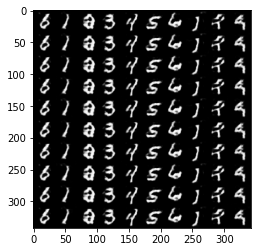

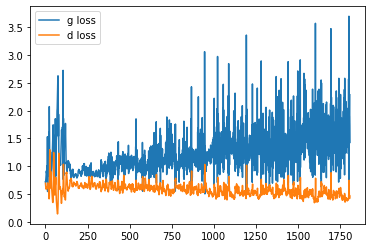

it: 1875; g_loss: 1.1990536451339722; d_loss: 0.47335973381996155; avg_real_score: 0.5871665477752686; avg_fake_score: 0.3129822015762329: : 469it [03:50,  2.03it/s]
it: 1876; g_loss: 2.147850751876831; d_loss: 0.4121946096420288; avg_real_score: 0.7940125465393066; avg_fake_score: 0.12029439210891724: : 0it [00:00, ?it/s]

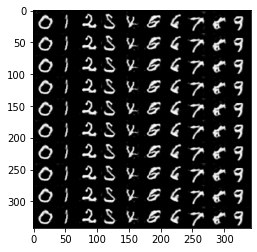

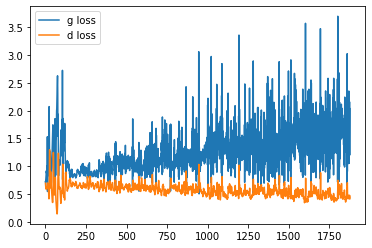

it: 2076; g_loss: 0.9741101264953613; d_loss: 0.4576883912086487; avg_real_score: 0.5699050426483154; avg_fake_score: 0.4048733413219452: : 200it [01:39,  2.02it/s]  

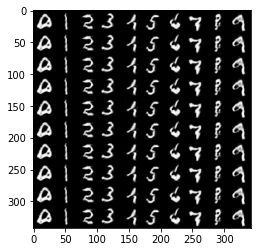

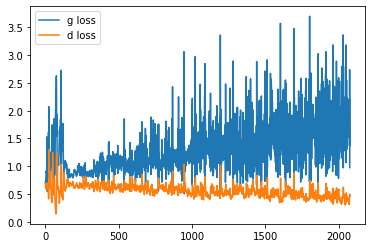

it: 2276; g_loss: 1.7398548126220703; d_loss: 0.34137171506881714; avg_real_score: 0.807780385017395; avg_fake_score: 0.19595760107040405: : 400it [03:18,  2.02it/s]

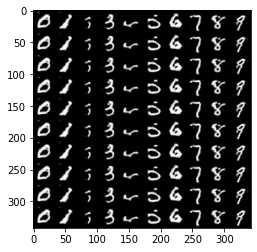

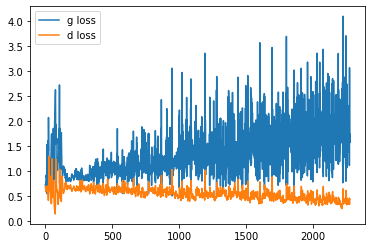

it: 2344; g_loss: 2.274251937866211; d_loss: 0.47654297947883606; avg_real_score: 0.789817214012146; avg_fake_score: 0.1079525351524353: : 469it [03:51,  2.02it/s]
it: 2345; g_loss: 1.115190029144287; d_loss: 0.4579572379589081; avg_real_score: 0.5730962157249451; avg_fake_score: 0.3400164544582367: : 0it [00:00, ?it/s]

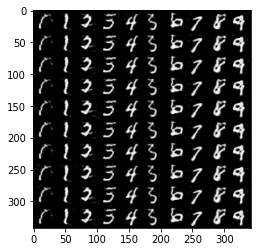

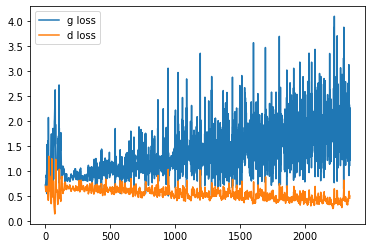

it: 2545; g_loss: 3.0793747901916504; d_loss: 0.3771076798439026; avg_real_score: 0.8597143888473511; avg_fake_score: 0.050499506294727325: : 200it [01:39,  2.04it/s]

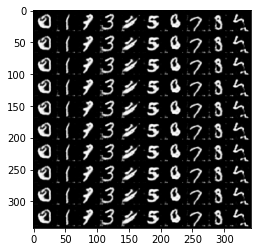

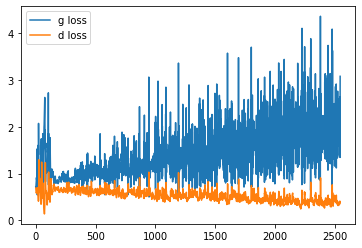

it: 2745; g_loss: 1.736148476600647; d_loss: 0.32596492767333984; avg_real_score: 0.7330615520477295; avg_fake_score: 0.19023752212524414: : 400it [03:18,  2.04it/s]

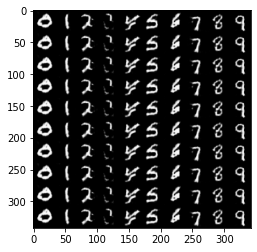

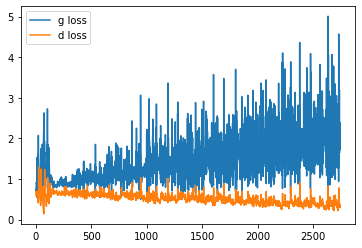

it: 2813; g_loss: 1.122322916984558; d_loss: 0.4637790322303772; avg_real_score: 0.6058576107025146; avg_fake_score: 0.3678298592567444: : 469it [03:52,  2.01it/s]
it: 2814; g_loss: 2.5392017364501953; d_loss: 0.4640215337276459; avg_real_score: 0.7958238124847412; avg_fake_score: 0.08681578934192657: : 0it [00:00, ?it/s]

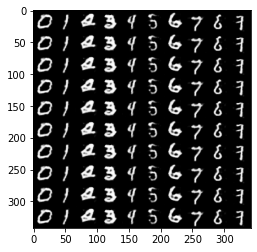

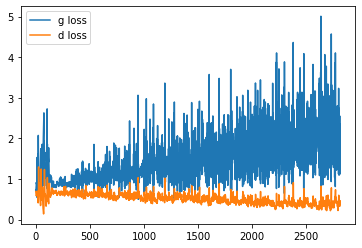

it: 3014; g_loss: 2.0411267280578613; d_loss: 0.3708268105983734; avg_real_score: 0.8083609342575073; avg_fake_score: 0.1385250836610794: : 200it [01:39,  2.04it/s]  

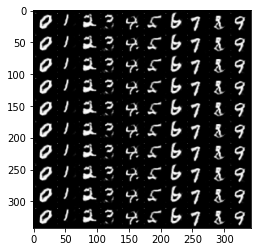

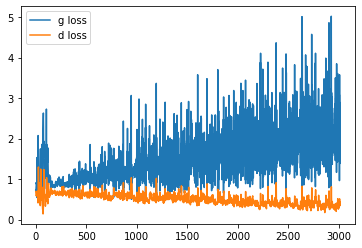

it: 3106; g_loss: 1.4551969766616821; d_loss: 0.407613605260849; avg_real_score: 0.663936972618103; avg_fake_score: 0.24433337152004242: : 293it [02:25,  2.04it/s]

In [ ]:
nb_epochs = 15

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)  # we generate the noise only once for testing


for epoch in range(nb_epochs):
    
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch 
        im = im.to(device)
        
        
        y = F.one_hot(labels).float().to(device)
        
        cur_batch_size = im.shape[0]  
        
        
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        
        # 1. sample a z vector 
        z = sample_z(im.shape[0], nz)
        
        # 2. Generate a fake image

        fake = netG(z, y)

        # 3. Classify real image with D

        real_class = netD(im, y)

        # 4. Classify fake image with D

        fake_class = netD(fake, y)

        
        
        ###
        ### Discriminator
        ###

        real_loss = criterion(real_class, get_labels_one(real_class.shape[0]))
        fake_loss = criterion(fake_class, get_labels_zero(fake_class.shape[0]))

        d_loss = (real_loss + fake_loss)/2
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()
        
        
        ###
        ### Generator
        ###

        fake = netG(z, y)
        fake_class = netD(fake, y)
        
        g_loss = criterion(fake_class, get_labels_one(fake_class.shape[0]))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = real_class.mean().item()
        avg_fake_score = fake_class.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        
        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)  
            
            plt.imshow(pil_grid)
            plt.show()
            
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1
            

## 4.2 Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

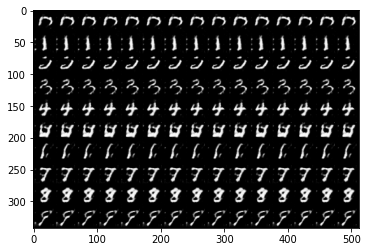

In [ ]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)  

plt.imshow(pil_grid)
plt.show()
